In [2]:
import pandas as pd
import numpy as np
import gensim,re,time
from gensim.models.fasttext import load_facebook_model
from nltk.tokenize import RegexpTokenizer,TreebankWordTokenizer
from code import utils
from sklearn.preprocessing import normalize
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, MeanShift, OPTICS
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.offline as py
import plotly.express as px
from gensim.test.utils import get_tmpfile
tokenizer = TreebankWordTokenizer()
from gensim.models import FastText

pca = PCA(n_components=3)
tsne = TSNE(n_components=3)

#Paramters
TOP_N_ARTICLES = 100000
TRAIN_N = 10000
%load_ext autoreload
%autoreload 2


Number of stopwords 607


### Load data and the model 

In [107]:
#df = utils.load_text_data()
#pdf=utils.preprocess_text(df.head(TOP_N_ARTICLES))
#tokenized_texts = [tokenizer.tokenize(txt) for txt in pdf ]

pdf[4]

'das hatte sich markus gisdol bei seiner vertragsverlängerung anfang august sicher auch alles ganz anders vorgestellt. kölns cheftrainer geht mit zehn sieglos-spielen aus der vergangenen rückrunde in die neue saison. und neben diesem rucksack muss er jetzt auch noch in kürzester zeit verletzte spieler ersetzen und eine neue offensive installieren der transfer von jhon cordoba nach berlin ist so gut wie perfekt nach bild-informationen soll dienstag alles klar sein. gisdol steht schon vorm start unter druck der wahnsinn gisdol weiß nicht mal wen er gegen hoffenheim sa. uhr auf den platz schicken kann. top-star jhon cordoba treffer letzte saison haut nach berlin ab. sein ersatz sebastian andersson kommt von union berlin muss wie herthas ondrej duda erst noch integriert werden. grieche dimitrios limnios paok saolniki sitzt nach wie vor mit positivem corona-test in der heimat fest. dazu kommen die vielen verletzten anthony modeste muss nach knie-problemen erst wieder anschluss finden. flori

In [8]:
start_time = time.time()

#fb_model = load_facebook_model("cc.de.300.bin")
fb_model = FastText.load("/var/folders/gd/3cfjnlf96qn463knfznfpncw0000gn/T/fasttext.model")
print("--- Model loaded in %s seconds ---" % (time.time() - start_time))
fb_model.wv.most_similar(positive=['covid'])


--- Model loaded in 20.667484760284424 seconds ---


[('covid.', 0.9796991944313049),
 ('Rudam', 0.9745489358901978),
 ('Rodovid', 0.9703274369239807),
 ('ovid', 0.9689452648162842),
 ('Pająk', 0.9664974212646484),
 ('Dovid', 0.9652129411697388),
 ('510002410', 0.9603769779205322),
 ('coviva', 0.9589679837226868),
 ('Covid', 0.9579055905342102),
 ('Leposavić', 0.9555858969688416)]

In [100]:
print('covid' in fb_model.wv.vocab)  # Word is out of vocabulary
print('covidioten' in fb_model.wv.vocab)  # Word is out of vocabulary
print('coronavirus' in fb_model.wv.vocab)  # Word is out of vocabulary

True
True
True


In [89]:
start_time = time.time()

fb_model.build_vocab(tokenized_texts, update=True)
fb_model.train(sentences=tokenized_texts, total_examples=len(tokenized_texts), epochs=15)
print("--- %s seconds ---" % (time.time() - start_time))


#fname = get_tmpfile("fasttext.model")
#fb_model.save(fname)

KeyboardInterrupt: 

In [102]:
fb_model.wv.most_similar(positive=["virus","corona"])


[('corona-virus', 0.9479460716247559),
 ('coronavirus', 0.9341956377029419),
 ('corona-virus.', 0.9262381792068481),
 ('coronavirus.', 0.9100427627563477),
 ('coronavirus’', 0.9067225456237793),
 ('coronavirusncov', 0.9047183990478516),
 ('corona-viren', 0.8907731771469116),
 ('coronaviren', 0.8807787895202637),
 ('Coronavirus', 0.8795601725578308),
 ('coronavirus-epidemie', 0.8773820996284485)]

In [52]:
from collections import Counter
import itertools

def map_word_frequency(document):
    return Counter(itertools.chain(document))
    
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=fb_model):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    word_counts = map_word_frequency((sentence1 + sentence2))
    print(word_counts)
    embedding_size = 300 # size of vectore in word embeddings
    a = 0.001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set


def get_sif_feature_vec(sentence1, word_emb_model=fb_model):
    sentence1 = [token for token in tokenizer.tokenize(sentence1) if token in word_emb_model.wv.vocab and token not in utils.STOPWORDS]
    word_counts = map_word_frequency((sentence1))
    #print(word_counts)
    embedding_size = 300 # size of vectore in word embeddings
    a = 0.001
    vs = np.zeros(embedding_size)
    sentence_length = len(sentence1)
    for word in sentence1:
        a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
        vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
    vs = np.divide(vs, sentence_length) # weighted average
    return vs

In [55]:
#sentences_from_text = [ utils.get_sentences_from_text(txt) for txt in pdf]
#sentences_from_text[5]
#get_sif_feature_vec(pdf[0])

start_time = time.time()

vectors = []
for text in pdf:
    vectors.append(get_sif_feature_vec(text))
print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-52-0531f6f887f3>:37: RuntimeWarning:

invalid value encountered in true_divide



--- 112.30100131034851 seconds ---


In [11]:
start_time = time.time()

#sentences_from_text = [ utils.get_sentences_from_text(txt) for txt in pdf]

#vectors = []
#for sentences in sentences_from_text:
#    ve=[]
#    for sen in sentences:
#        ve.append(np.array(fb_model[sen]))
#    vectors.append(np.mean(ve,axis=0))
#print("--- %s seconds ---" % (time.time() - start_time))
    

<ipython-input-11-3e8c68f9c425>:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Users/tomasztkaczyk/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning:

Mean of empty slice.

/Users/tomasztkaczyk/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



--- 268.2316310405731 seconds ---


In [59]:
len(vectors[:500]),vectors[0].shape

(500, (300,))

In [14]:
pd.DataFrame(np.array(vectors)).to_csv("./tmps")

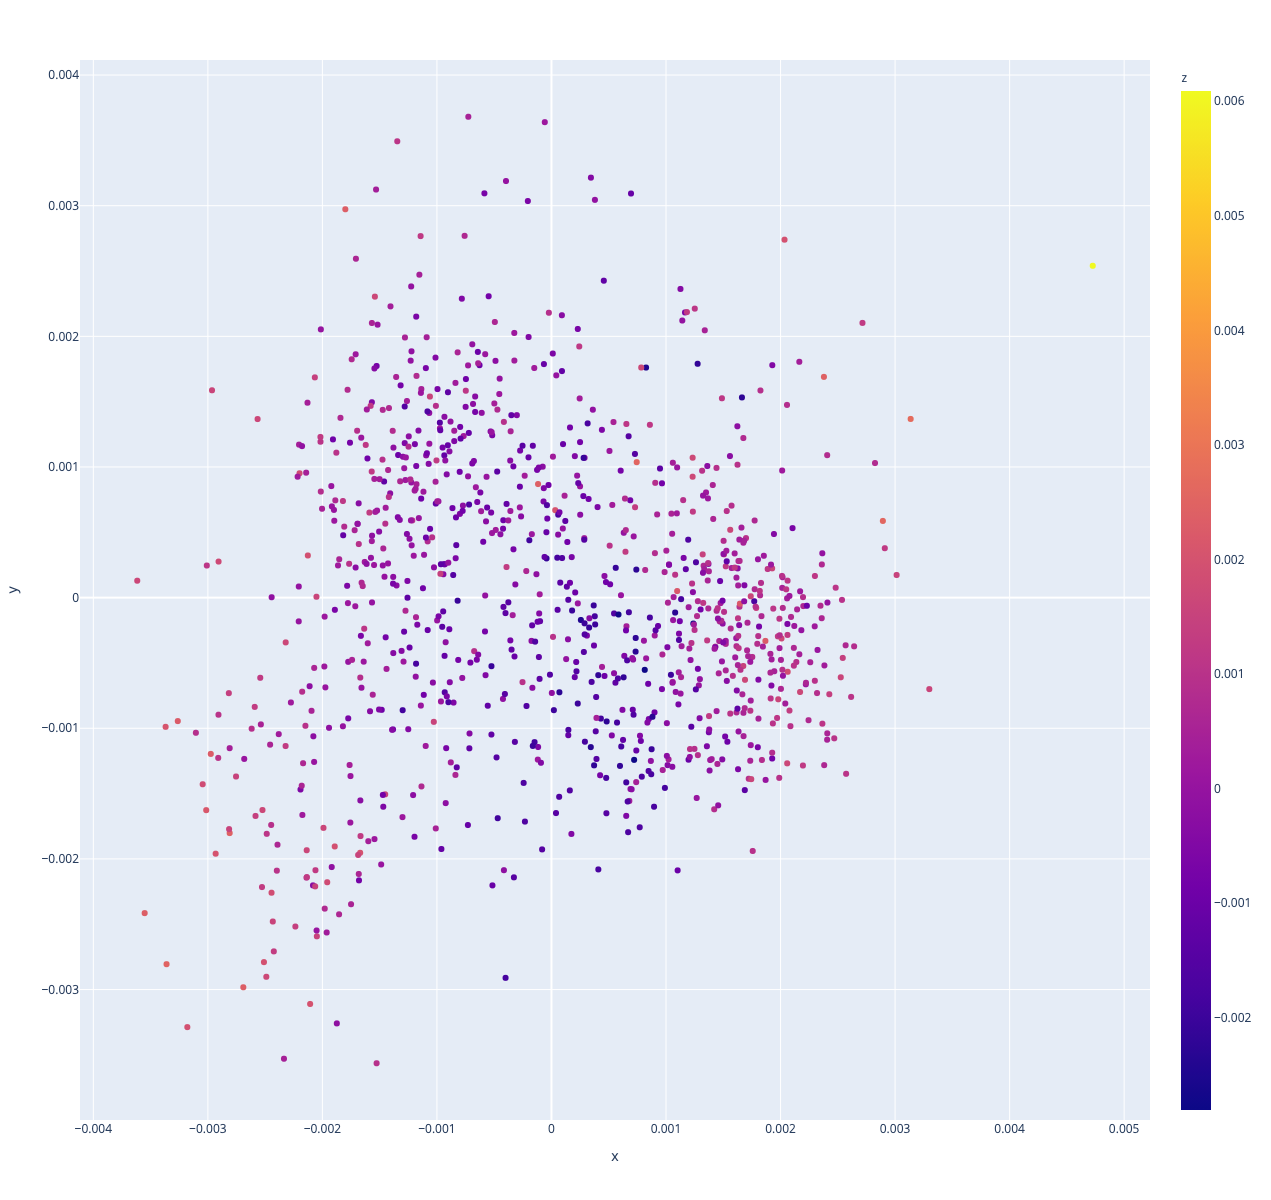

In [111]:
p = pca.fit_transform(np.array(vectors[:1000]))
p = pd.DataFrame(p,columns=["x",'y','z'])
p['headline'] = df.head(1000)["headline"].values
fig = px.scatter(p, x="x", y="y",hover_name="headline", color = "z", size_max=60)
fig.update_layout(
     height=1200)
fig.show()

/Users/tomasztkaczyk/opt/anaconda3/envs/py38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:217: UserWarning:

Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 



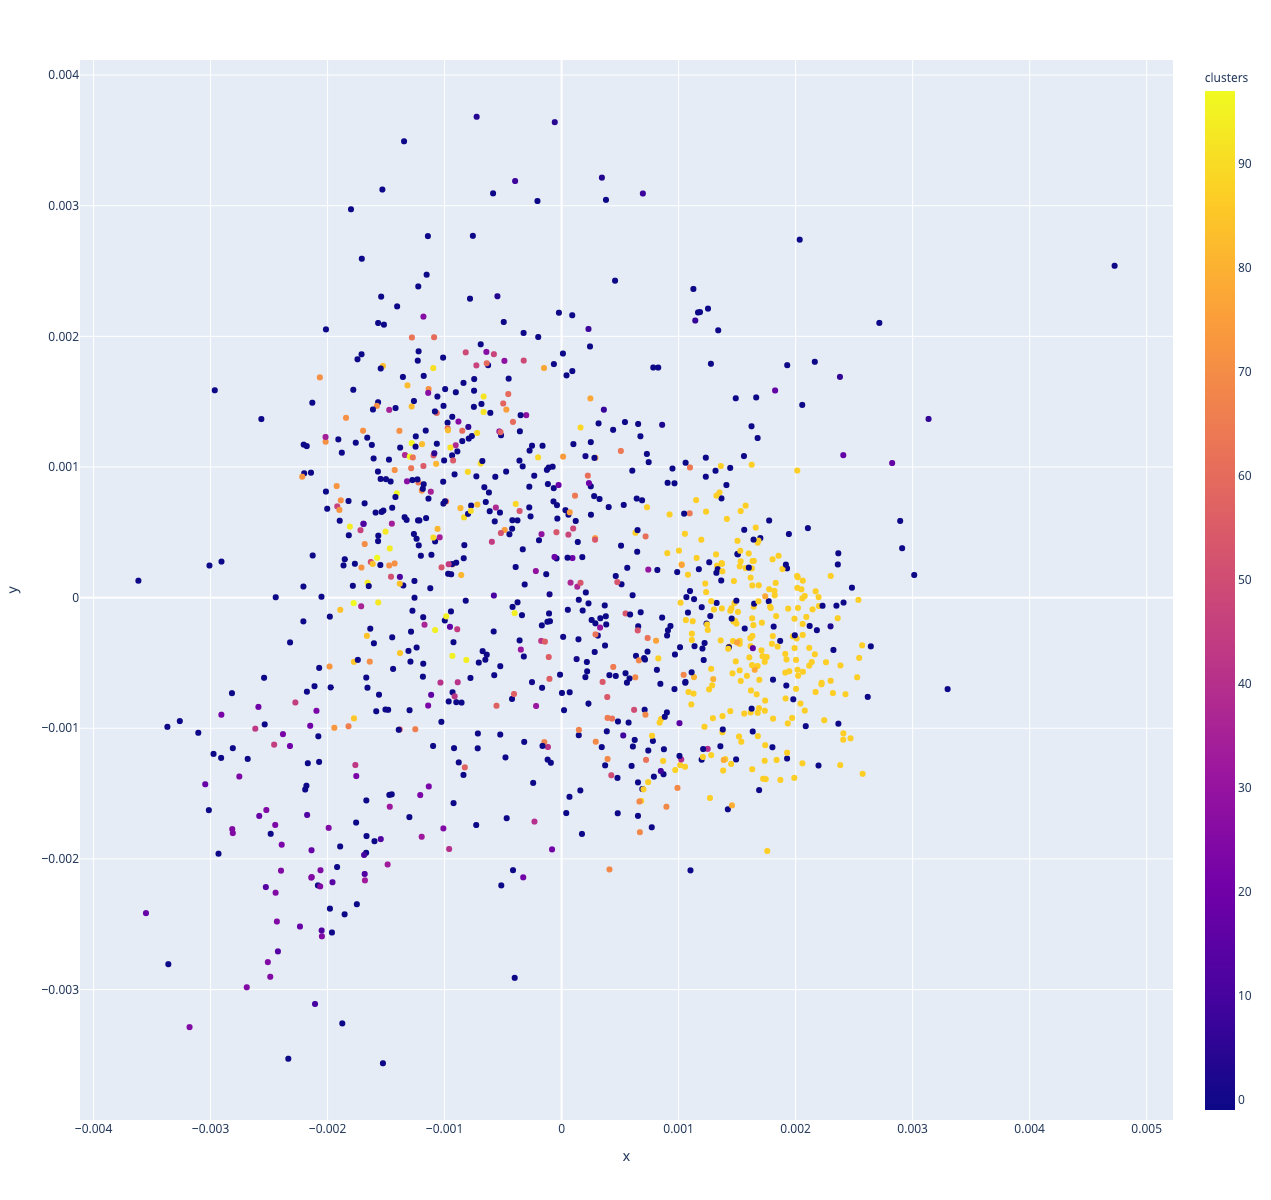

In [115]:
clusterer = HDBSCAN(algorithm='best', alpha=0.5, approx_min_span_tree=False,
    gen_min_span_tree=True, leaf_size=20,
metric='euclidean', min_cluster_size=2, min_samples=2, p=None)

#clusterer = DBSCAN(metric=cosine_distances)

cluster_labels = clusterer.fit_predict(normalize(vectors[:1000],norm="l2"))
p["clusters"] = cluster_labels
fig = px.scatter(p, x="x", y="y",hover_name="headline", color = "clusters", size_max=60)
fig.update_layout(
     height=1200)

In [9]:
import umap
import umap.plot


mapper = umap.UMAP().fit(vectors)
umap.plot.points(mapper, labels=digits.target)

NameError: name 'vectors' is not defined